In [40]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn

import gymnax
import equinox as eqx
import dill
import matplotlib.pyplot as plt

from helpers import dataloader, rollout_parallel
from ode import train_dynamics
from models import NeuralNetwork, NeuralODE
from helpers import rollout_parallel
import os

In [6]:
def rollout_on_real_sys(key, params, model_static, env_params, n_trajectories):
    # Rollout 
    keys_rollout = jr.split(key, n_trajectories)
    obss, actionss, rewardss, _, _= rollout_parallel(keys_rollout, params, model_static, env_params)
    # Return data
    data = jnp.concatenate([obss, jnp.expand_dims(actionss, axis=-1)], axis=2)
    # Get length of rollout
    ts = jnp.linspace(0, env_params.dt * env_params.max_steps_in_episode, env_params.max_steps_in_episode)

    return ts, data, rewardss

In [32]:
SEED = 0
key_policy, key_rollout, key_ODE = jr.split(jr.PRNGKey(SEED), 3)

# Generate rollout on policy
with open('../checkpoints/isolated_training/new_policy.pkl', 'rb') as file:
    policy = dill.load(file)

policy_params, policy_static = eqx.partition(policy, eqx.is_inexact_array)
_, env_params = gymnax.make("Pendulum-v1")
n_trajectories = 100
ts, data, reward = rollout_on_real_sys(key_rollout, policy_params, policy_static, env_params, n_trajectories)

# Train ODE with rolllout data
ODE_model = NeuralODE(4, 3, width_size=20, depth=4, key=key_ODE)
ODE_params, ODE_static = eqx.partition(ODE_model, eqx.is_inexact_array)
ys, losses, ODE_model = train_dynamics(data, ts, ODE_params, ODE_static, key=key_ODE, 
                                       lr_strategy=(3e-3, 3e-3, 3e-3, 3e-3),
                                       steps_strategy=(1000, 1000, 1000, 1000), 
                                       length_strategy=(0.10, 0.25, 0.50, 1.0))

Step: 0, Loss: 5.640472888946533, Computation time: 13.650949239730835
Step: 100, Loss: 2.1009583473205566, Computation time: 0.05602312088012695
Step: 200, Loss: 0.8591886758804321, Computation time: 0.042226552963256836
Step: 300, Loss: 1.0528569221496582, Computation time: 0.05476951599121094
Step: 400, Loss: 0.3826937675476074, Computation time: 0.047414541244506836
Step: 500, Loss: 0.5404631495475769, Computation time: 0.050048112869262695
Step: 600, Loss: 0.4604273736476898, Computation time: 0.03308868408203125
Step: 700, Loss: 0.3684523403644562, Computation time: 0.034815311431884766
Step: 800, Loss: 0.14478163421154022, Computation time: 0.04542732238769531
Step: 900, Loss: 0.1275232881307602, Computation time: 0.04683208465576172
Step: 999, Loss: 0.0627080649137497, Computation time: 0.036641836166381836
Step: 0, Loss: 3.359301805496216, Computation time: 11.864139080047607
Step: 100, Loss: 1.6281352043151855, Computation time: 0.047684431076049805
Step: 200, Loss: 0.8316894

In [41]:
checkpoint_path = "../checkpoints/isolated_training/new_dynamics.pkl"
if not os.path.exists(os.path.dirname(checkpoint_path)):
    os.mkdir(os.path.dirname(checkpoint_path))

with open(checkpoint_path, 'wb') as file:
    dill.dump(ODE_model, file)           

: 

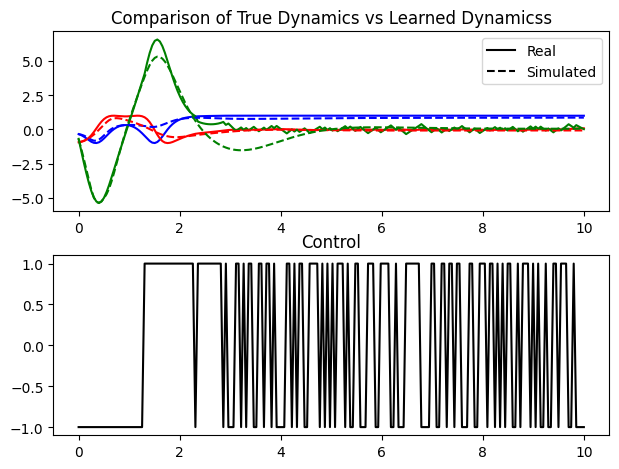

In [33]:
y0 = data[0, 0, :-1]
us = data[0, :, -1]

# Real dynamics
fig, axes = plt.subplots(2, 1)
axes[0].plot(ts, data[0, :, 0], c="blue")
axes[0].plot(ts, data[0, :, 1], c="red")
axes[0].plot(ts, data[0, :, 2], c="green")

model_y = ODE_model(ts, y0, us)

# Sim dynamics
axes[0].plot(ts, model_y[:, 0], c="blue", linestyle='--')
axes[0].plot(ts, model_y[:, 1], c="red", linestyle='--')
axes[0].plot(ts, model_y[:, 2], c="green", linestyle='--')

#Labels
axes[0].plot([], label='Real', color='black')
axes[0].plot([], label='Simulated', linestyle='--', color='black')


axes[0].set_title('Comparison of True Dynamics vs Learned Dynamicss')
axes[0].legend()
plt.tight_layout()

axes[1].plot(ts, us, c="black", alpha=1.0, label='control')
axes[1].set_title("Control")
plt.show()

Text(0.5, 0.98, 'Loss Curve for Neural ODE')

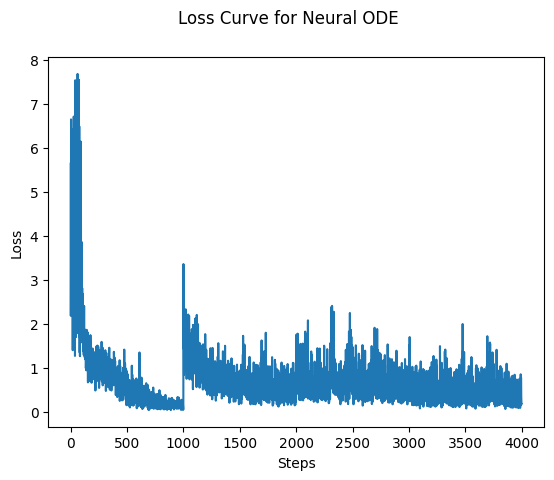

In [38]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.suptitle("Loss Curve for Neural ODE")
